# GCC's ssc-cdi : tomography pipeline for Cateretê v0.6.36
 
- #### Questions? E-mail gcc@lnls.br
- #### Documentation about the ssc-cdi package: https://gcc.lnls.br/wiki/

## Imports

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import json
import sscCdi
import sscRaft

import os, sys, time, ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imsave
from functools import partial
from concurrent.futures import ProcessPoolExecutor

import sscRaft, sscRadon

from sscCdi.misc import save_json_logfile, create_directory_if_doesnt_exist, save_json_logfile_tomo, open_or_create_h5_dataset
from sscCdi.processing.unwrap import remove_phase_gradient, unwrap_in_parallel


print(f'sscCdi version: {sscCdi.__version__}')
print(f'sscRaft version: {sscRaft.__version__}')

plt.rcParams['image.cmap'] = 'cividis'

-.RAFT_PARALLEL_EM-
sscCdi version: 0.6.39
sscRaft version: 2.2.7


In [2]:
import tomopy
from tomo_processing import *
from alignment import alignment_variance_field, alignment_vertical_mass_fluctuation
import alignment

## Load dictionary

In [3]:
dic = {}

## Load data

In [4]:
# dic["recon_method"]  = "ptycho" # ptycho or pwcdi
# dic["contrast_type"] = "complex" # phase, magnitude or complex
# # dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/proposals/20222075/proc/recons/a1_04/2024-01-12-14h01m_a1_04.hdf5"
# dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/proposals/20222150/proc/recons/A2_02/2023-07-28-14h16m_A2_02.hdf5"
# dic = sscCdi.define_paths(dic)

# obj, angles = sscCdi.read_data(dic)
# print(f"Object shape = {obj.shape} \t Number of angles: {angles.shape}")

In [5]:
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/angles.npy'
# # np.save(path,angles)
# angles = np.load(path)

## Crop data

In [6]:
# dic["top_crop"]    = 1300 # n of pixels to remove on top
# dic["bottom_crop"] = 2500 # n of pixels to remove on bottom
# dic["left_crop"]   = 1200 # n of pixels to remove on left
# dic["right_crop"]  = 1400 # n of pixels to remove on right

In [7]:
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/cropped.npy'
# # cropped_data = tomo_crop(dic,obj,save=False)
# cropped_data = np.load(path)
# # np.save(path,cropped_data)

In [8]:
# plt.figure()
# plt.imshow(np.angle(np.mean(cropped_data,axis=0)))

In [9]:
# path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/cropped.npy'
# # np.save(path,cropped_data)

## Sort data

In [10]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/sorted.npy'
path2 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/angles_sorted.npy'
# sorted_data, sorted_angles = tomo_sort(dic,cropped_data, angles,save=False)
# np.save(path,sorted_data)
# np.save(path2,sorted_angles)
sorted_data = np.load(path)
sorted_angles = np.load(path2)

sorted_data.shape, sorted_angles.shape

((550, 947, 2147), (550, 2))

## Alignment: Cross Correlation (CC) and Vertical Mass Fluctuation (VMF)

In [21]:
aligned_data_CC3 = alignment_variance_field(sorted_data, downscaling_factor=4, use_gradient = True, fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True)

Downscaling images for alignment...
Finding shift between neighboor slices...
Finding shift between slices #0/550
Finding shift between slices #50/550
Finding shift between slices #100/550
Finding shift between slices #150/550
Finding shift between slices #200/550
Finding shift between slices #250/550
Finding shift between slices #300/550
Finding shift between slices #350/550
Finding shift between slices #400/550
Finding shift between slices #450/550
Finding shift between slices #500/550
Shifting slice #0/550
Shifting slice #50/550
Shifting slice #100/550
Shifting slice #150/550
Shifting slice #200/550
Shifting slice #250/550
Shifting slice #300/550
Shifting slice #350/550
Shifting slice #400/550
Shifting slice #450/550
Shifting slice #500/550


In [11]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/alignedCC.npy'
# np.save(path,aligned_data_CC3)
alignedCC = np.load(path)

Calculating 1D mass distribution...
Finding shift between neighboor slices...
Shifting slices...
Aligning volume...
Aligning slice #0/550
Aligning slice #50/550
Aligning slice #100/550
Aligning slice #150/550
Aligning slice #200/550
Aligning slice #250/550
Aligning slice #300/550
Aligning slice #350/550
Aligning slice #400/550
Aligning slice #450/550
Aligning slice #500/550


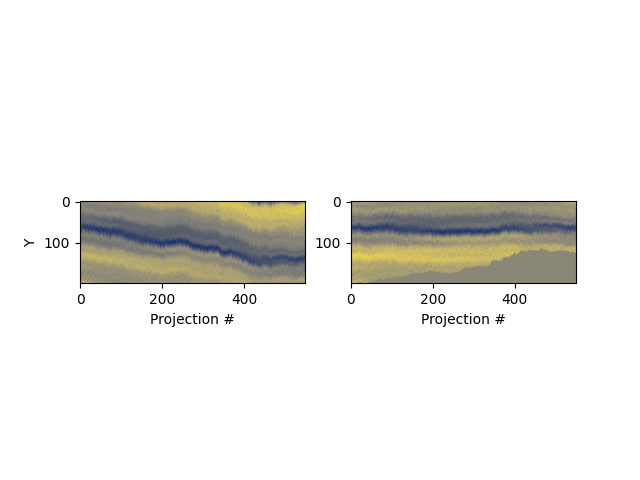

In [23]:
alignedVMF, curves, total_shift = alignment_vertical_mass_fluctuation(alignedCC, curve_portion = (100,300),  use_phase_gradient = True,  filter_sigma = 0, return_common_valid_region=True, remove_null_borders = True, plot = 0) # if data is not equalized, phase gradient should be used

In [12]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/aligned_data_VMF.npy'
# np.save(path,alignedVMF)
alignedVMF = np.load(path)

Calculating 1D mass distribution...
Calculating 1D mass distribution...


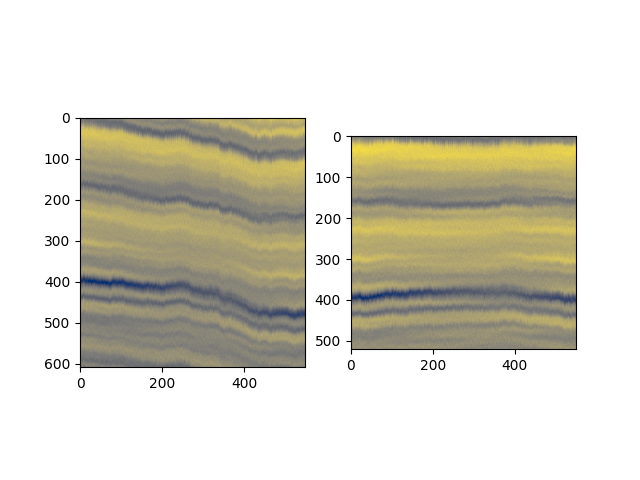

In [29]:
curves0 = get_VMF_curves(alignedCC,use_phase_gradient=True,filter_sigma=0,curve_portion=None)
curves = get_VMF_curves(alignedVMF,use_phase_gradient=True,filter_sigma=0,curve_portion=None)

fig, ax = plt.subplots(1,2)
ax[0].imshow(curves0.T)
ax[1].imshow(curves.T)

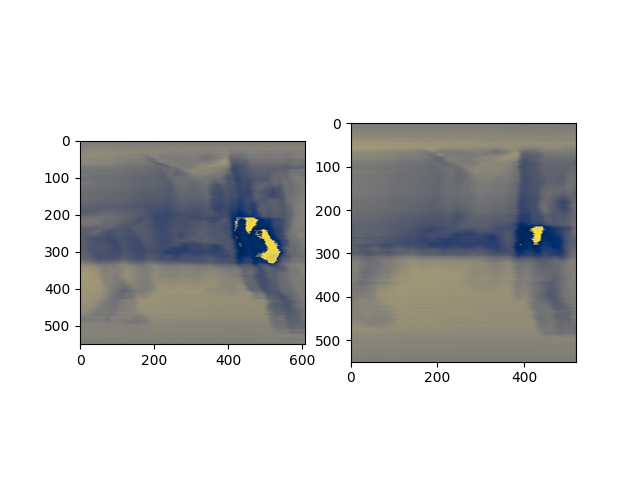

In [13]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.angle(alignedCC[:,:,alignedCC.shape[1]//2]))
ax[1].imshow(np.angle(alignedVMF[:,:,alignedVMF.shape[1]//2]))

## Unwrap

In [9]:
# unwrappedVMF = unwrap_in_parallel(np.angle(alignedVMF))
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/unwrappedVMF.npy'
# np.save(path,unwrappedVMF)
unwrappedVMF = np.load(path)

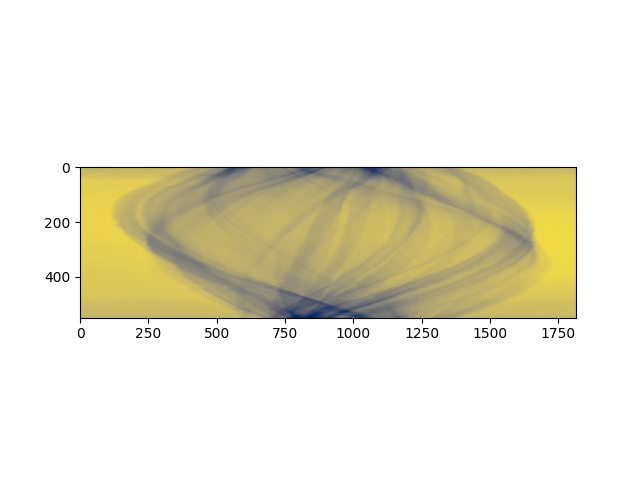

In [33]:
fig, ax = plt.subplots()
# ax.imshow(np.mean(np.angle(aligned_data_VMF),axis=0))
ax.imshow(unwrappedVMF[:,unwrappedVMF.shape[1]//2,:])

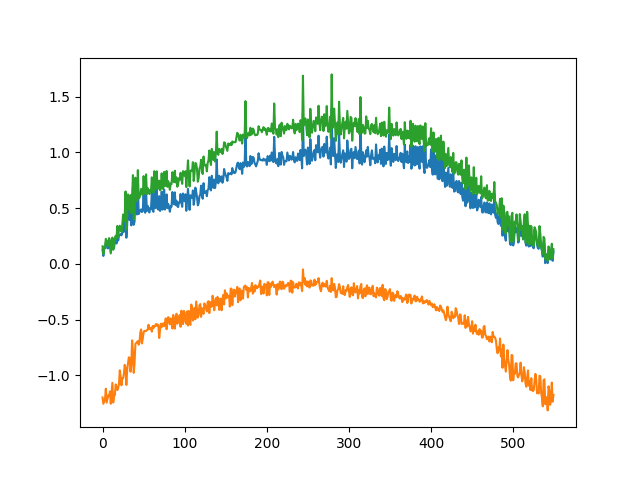

In [51]:
# unwrappedVMF[:,:,100:1750]=0
ROI_mean = unwrappedVMF[:,400::,1800::].mean(axis=2).mean(axis=1)
ROI_mean2 = unwrappedVMF[:,0::,::20].mean(axis=2).mean(axis=1)
ROI_mean3 = unwrappedVMF[:,0:200,1800::].mean(axis=2).mean(axis=1)

fig, ax = plt.subplots()
ax.plot(ROI_mean)
ax.plot(ROI_mean2)
ax.plot(ROI_mean3)

## 2D Equalization

In [36]:
dic={}
dic["bad_frames_before_equalization"] = []
dic["CPUs"] = 32

dic["equalize_invert"] = True # invert phase shift signal from negative to positive
# dic["equalize_ROI"] = [500,600,1750,1800] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_ROI"] = [0,500,0,50] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_remove_phase_gradient"] = True  # if empty and equalize_ROI = [], will subtract best plane fit from whole image
dic["equalize_remove_phase_gradient_iterations"] = 0
dic["equalize_local_offset"] = True # remove offset of each frame from the mean of ROI 
dic["equalize_set_min_max"]= [] # [minimum,maximum] threshold values for whole volume
dic["equalize_non_negative"] = False # turn any remaining negative values to zero

In [37]:
equalized_sinogram = tomo_equalize(dic,unwrappedVMF)

Sinogram shape to equalize:  (550, 539, 1815)
Using 32 parallel processes


100%|██████████| 550/550 [00:09<00:00, 55.99it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old -0.45, -4.45, 1.09, 6.64,10.19
New: -3.02, -2.28,1.30, 4.88,10.89
Time elapsed: 17.19 s


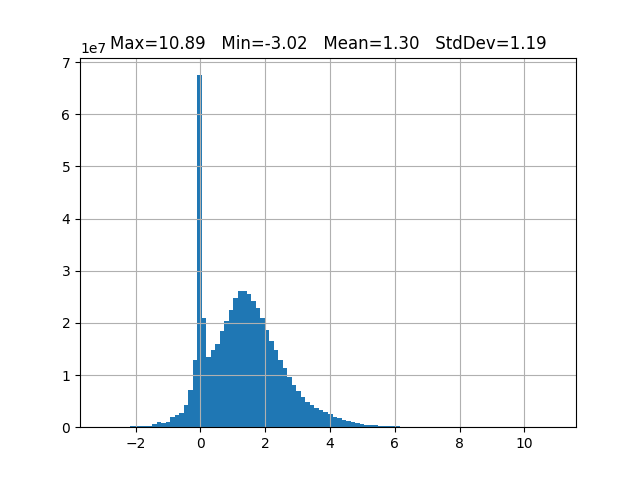

In [38]:
sscCdi.misc.plot_volume_histogram(equalized_sinogram)

In [39]:
# sscCdi.deploy_visualizer(equalized_sinogram,title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto')

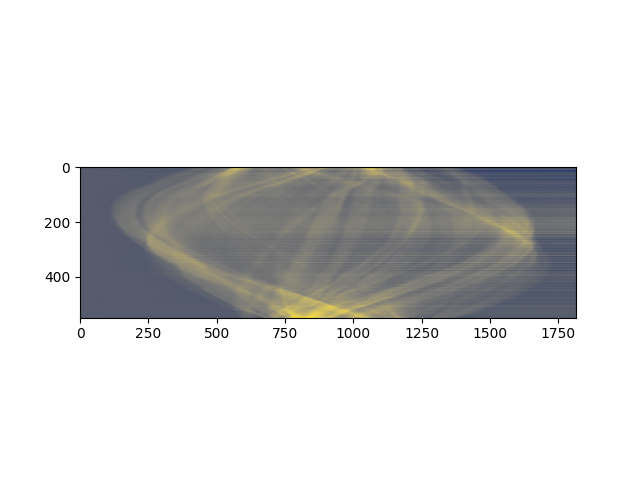

In [40]:
fig, ax = plt.subplots()
ax.imshow(equalized_sinogram[:,equalized_sinogram.shape[1]//2,:])

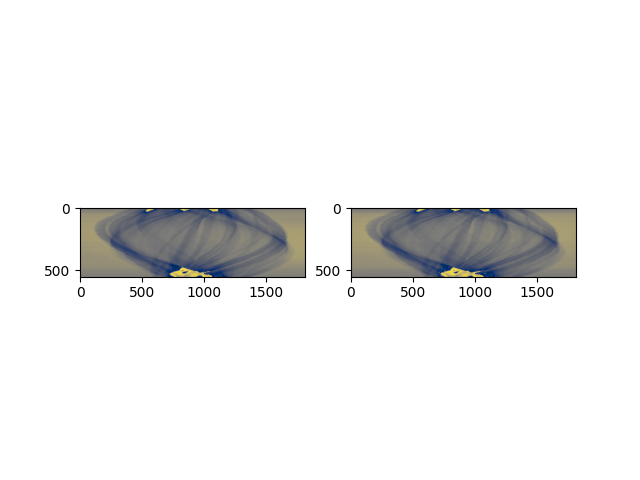

In [19]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.angle(aligned_data_VMF[:,aligned_data_VMF.shape[1]//2,:]))
ax[1].imshow(np.angle(equalized2[:,equalized2.shape[1]//2,:]))

In [15]:
def rmphaseramp(a, weight=None, return_phaseramp=False):

    """
    CREDITS:
    ----
    Function adapted from Ptypy.plot_utils (https://github.com/ptycho/ptypy)

    """
    useweight = True
    if weight is None:
        useweight = False
    elif weight == "abs":
        weight = np.abs(a)

    ph = np.exp(1j * np.angle(a))
    [gx, gy] = np.gradient(ph)
    gx = -np.real(1j * gx / ph)
    gy = -np.real(1j * gy / ph)

    if useweight:
        nrm = weight.sum()
        agx = (gx * weight).sum() / nrm
        agy = (gy * weight).sum() / nrm
    else:
        agx = gx.mean()
        agy = gy.mean()

    (xx, yy) = np.indices(a.shape)
    p = np.exp(-1j * (agx * xx + agy * yy))

    if return_phaseramp:
        return a * p, p
    else:
        return a * p


equalized2 = np.empty_like(aligned_data_VMF,dtype=complex)
for i, frame in enumerate(aligned_data_VMF):
    if i%50==0: print(i)
    equalized2[i] = rmphaseramp(frame)

0
50
100
150
200
250
300
350
400
450
500


In [ ]:
# equalized_sinogram -= np.min(equalized_sinogram)

path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/equalized.npy'
# np.save(path,equalized_sinogram)
equalized_sinogram = np.load(path)

## Tomography: select dictionary according to tomographic method
- for details on the tomography algorithm inputs, see documentation at https://gcc.lnls.br/wiki/docs/ssc-raft/reconstructions/

In [7]:
dic = {}
dic['using_wiggle'] = False
dic["project_angles_to_regular_grid"] = False

dic['automatic_regularization'] = 0 # skip if 0; regularization between 0 and 1 to enhance borders prior to recon (https://www.sciencedirect.com/science/article/pii/S2590037419300883?via%3Dihub)

dic["algorithm_dic"] = { # if FBP: filtered back-projection
    'algorithm': "FBP",
    'gpu': [0],
    'filter': 'lorentz', # 'gaussian','lorentz','cosine','rectangle'
    'regularization': 0.1, # 0 <= regularization <= 1; use for smoothening
    'shift center':0,
}

# dic["algorithm_dic"] = { # if eEM: emission expectation maximization
#     'algorithm': "EM",
#     'gpu': [0],
#     'regularization': 0.1,
#     'method': 'eEM', 
#     'niterations': [20,0,0,0], # [global iterations, iterations EMTV, iterations2 EMTV, Cone-beam integration points]
#     'epsilon': 1e-15, #for EMTV only
#     'blocksize': 20, # blocks for parallelization
# }

In [8]:
# # sinogram = np.load(dic["equalized_sinogram_filepath"])
# sinogram = np.load(dic["wiggle_sinogram_filepath"])

dic["ordered_angles_filepath"] = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/angles_sorted.npy'
# a = unwrappedVMF - np.min(unwrappedVMF)
recon3D2 = tomo_recon(dic,-unwrappedVMF,save=False)

path =  '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomo_EM20_VMF.npy'
# np.save(path,recon3D2)

NameError: name 'unwrappedVMF' is not defined

In [ ]:
sscCdi.deploy_visualizer(recon3D,title="Recon",cmap='gray',axis=0)#,limits=(-1,1))

In [10]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomo_EM20.npy'
# np.save(path,recon3D2)
recon3D = np.load(path)

In [ ]:
projection3D = np.sum(recon3D,axis=1)

In [ ]:
path = '/ibira/lnls/beamlines/caterete/proposals/20222150/proc/recons/A2_02/tomo_20iter/2023-07-28-14h16m_A2_02_complex_tomo_equalized.npy'
path = '/ibira/lnls/beamlines/caterete/proposals/20222150/proc/recons/A2_02/retomo_40iter/2023-07-28-14h16m_A2_02_complex_tomo_equalized.npy'
recon3D2 = np.load(path)
print(recon3D2.shape)
projection3D2 = np.sum(recon3D2,axis=1)

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,5),dpi=200)
ax[0].imshow(equalized_sinogram[277]), ax[0].set_title('Ptycho') 
ax[1].imshow(projection3D), ax[1].set_title('New CC ')
ax[2].imshow(projection3D2[100:750,0:-20]), ax[2].set_title('Old CC ')


In [ ]:
# aligned_tomopy =  tomopy.prep.alignment.align_joint(equalized_sinogram, sorted_angles[:,1]*np.pi/180, fdir='./', iters=20, pad=(0, 0), blur=True, center=None, algorithm='sirt', upsample_factor=10, rin=0.5, rout=0.8, save=True, debug=True)

path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/tomopy_seq.npy'
# np.save(path,aligned_tomopy[0])
aligned = np.load(path)

In [ ]:
# tomo3D = tomopy.recon(unwrapped3, sorted_angles, algorithm='sirt',ncore=32)

In [ ]:
recon3D2[recon3D2>20] = 0
# sscCdi.misc.plot_volume_histogram(recon3D2)

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,5),dpi=200)
ax[0].imshow(-unwrapped3[275])
ax[1].imshow(np.sum(recon3D,axis=1))
ax[2].imshow(np.sum(recon3D2,axis=1))#,norm=LogNorm())
ax[0].set_title('Ptycho')
ax[1].set_title('CC+EM')
ax[2].set_title('CC+VMF+EM')

## Wiggle

In [8]:
import sscRaft, sscRadon

Simulating projection of angles to regular grid...
Before+after frames added: 68
Intermediate null frames : 1
                        + -----
Total null frames        : 69
Frames being used        : 394  of  550
                        + -----
Projected Angles         : 463
(550, 539, 1815)
ssc-radon: creating 550x539x1815 shared arrays (tomogram)


Text(0.5, 1.0, 'CC+VMF+Wiggle')

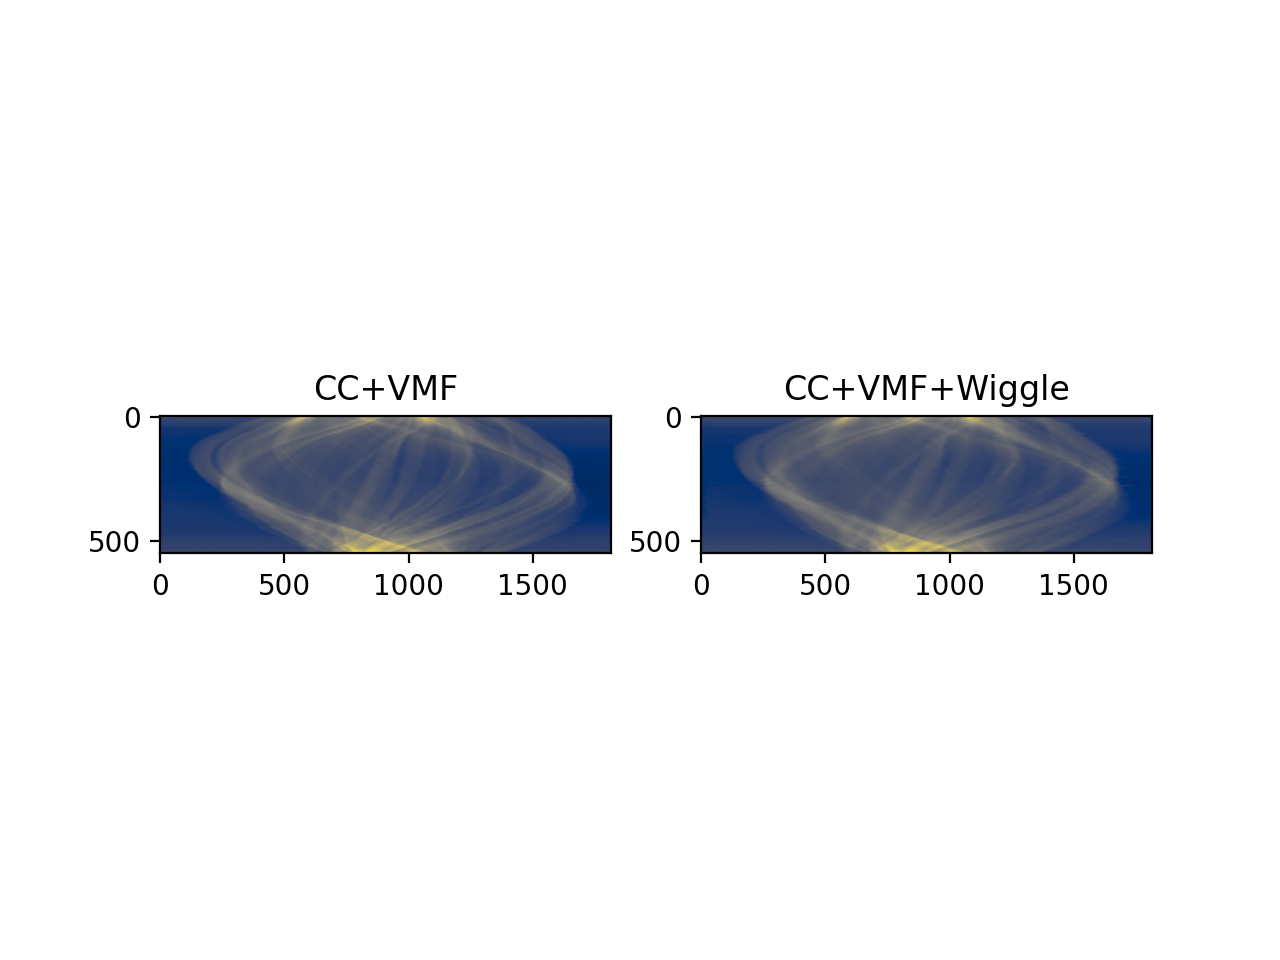

In [23]:
def preview_angle_projection(dic,angles,sinogram):
    """ Simulates the projection of angles to regular grid

    Args:
        dic (dict): dictionary with necessary parameters
            keys:
                "ordered_angles_filepath"
                "wiggle_sinogram_selection"
                "step_percentage"
    """    

    print("Simulating projection of angles to regular grid...")
    # angles  = np.load(dic["ordered_angles_filepath"])
    angles = (np.pi/180.) * angles
    total_n_of_angles = angles.shape[0]
    
    _, selected_indices, n_of_padding_frames, projected_angles = angle_grid_organize(
                                                                    sinogram, 
                                                                    angles,percentage=dic["step_percentage"]
                                                                )
    n_of_negative_idxs = len([ i for i in selected_indices if i < 0])
    selected_positive_indices = [ i for i in selected_indices if i >= 0]
    complete_array = [i for i in range(total_n_of_angles)]

    # print('Selected indices: \n',selected_indices)
    print('Before+after frames added:',n_of_padding_frames)
    print('Intermediate null frames :',len([ i for i in selected_indices if i < -1]))
    print('                        + -----')
    print("Total null frames        :", n_of_negative_idxs)
    print("Frames being used        :", len(selected_positive_indices)," of ",len(complete_array))
    print('                        + -----')
    print('Projected Angles         :', projected_angles.shape[0])
    
# temp_tomogram, shift_vertical = sscRadon.radon.get_wiggle( unwrapped3, "vertical", 32, 10 )

dic["step_percentage"] = 50 # need to project irregular angle steps to a regular grid?


path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/A2_02/unwrappedVMF.npy'
unwrappedVMF = np.load(path)
# unwrappedVMF = np.pad(unwrappedVMF,((0,0),(100,100),(100,100)))
unwrappedVMF *= -1
unwrappedVMF -= np.min(unwrappedVMF)

preview_angle_projection(dic,sorted_angles,unwrappedVMF)

sinogram_projected = unwrappedVMF
# sinogram_projected, _, _, projected_angles = angle_grid_organize(unwrappedVMF, sorted_angles*np.pi/180,percentage=dic["step_percentage"])
print(sinogram_projected.shape)

aligned_sinogram, shift_horizontal, wiggle_cmas_temp = sscRadon.radon.get_wiggle( sinogram_projected, "horizontal", 32, 10 )
wiggle_cmas = [[],[]]
wiggle_cmas[1], wiggle_cmas[0] =  wiggle_cmas_temp[:,1].tolist(), wiggle_cmas_temp[:,0].tolist()

# if 0: 
#     print("\tApplying wiggle center-of-mass correction to 3D reconstructed slices...")
#     reconstruction3D = sscRadon.radon.set_wiggle(reconstruction3D, 0, -np.array(wiggle_cmas[1]), -np.array(wiggle_cmas[0]), dic["CPUs"])
    
fig, ax = plt.subplots(1,2,dpi=200)
ax[0].imshow(sinogram_projected[:,sinogram_projected.shape[1]//2,:])#[50:200,300:400])
ax[1].imshow(aligned_sinogram[:,aligned_sinogram.shape[1]//2,:])#[50:200,300:400])
ax[0].set_title("CC+VMF")
ax[1].set_title("CC+VMF+Wiggle")

## PMA

In [11]:
recon3D_coarse = recon3D[0::4,0::4,0::4]

pad = (unwrappedVMF.shape[2]-unwrappedVMF.shape[1])//2
unwrappedVMF = np.pad(unwrappedVMF,((0,0),(pad+1,pad),(0,0)))
unwrapped3_coarse = unwrappedVMF[:,0::4,0::4]

pad = (recon3D_coarse.shape[1]-recon3D_coarse.shape[0])//2
recon3D_coarse = np.pad(recon3D_coarse,((pad+1,pad),(0,0),(0,0)))

sorted_angles.shape, recon3D.shape, recon3D_coarse.shape, unwrapped3_coarse.shape

((550, 2), (609, 1815, 1815), (454, 454, 454), (550, 454, 454))

In [12]:
from scipy.ndimage import rotate

def rotate_matrix(matrix,angle,rotation_point=None):
    
    if rotation_point == None:
        rotation_point = (matrix.shape[0]//2,matrix.shape[1]//2)

    real_part, imag_part = matrix.real, matrix.imag 
    rotated_matrix = rotate(real_part,angle,axes=(0,2),reshape=False)
    
    return rotated_matrix


In [13]:
import sscRaft
sscRaft.__version__

'2.2.7'

In [14]:
# np.save('/ibira/lnls/labs/tepui/home/yuri.tonin/dado.npy',recon3D_coarse)
# np.save('/ibira/lnls/labs/tepui/home/yuri.tonin/angles.npy',sorted_angles[:,1]*np.pi/180)

In [15]:
if 1:
    reprojection = sscRaft.geometries.gp.radon.radon_gpu(recon3D_coarse,sorted_angles[:,1]*np.pi/180,[0])
    reprojection = np.swapaxes(reprojection,0,1)
    # reprojection = np.swapaxes(reprojection,2,1)
    # reprojection = np.roll(reprojection,reprojection.shape[1]//2,axis=1)
    print(reprojection.shape)
# else:
#     from scipy.ndimage import rotate
#     reprojection = np.empty_like(unwrapped3_coarse)
#     for i,angle in enumerate(sorted_angles[:,1]):
#         if i%2==0: print(i)
#         reprojection[i] = np.sum(rotate_matrix(recon3D_coarse,angle,rotation_point=None),axis=0)

# reprojection2 = np.roll(reprojection,(10,10),axis=(1,2))        

(550, 454, 454)


In [37]:
sscCdi.deploy_visualizer(reprojection,title="Recon",cmap='gray',axis=1)#,limits=(-1,1))

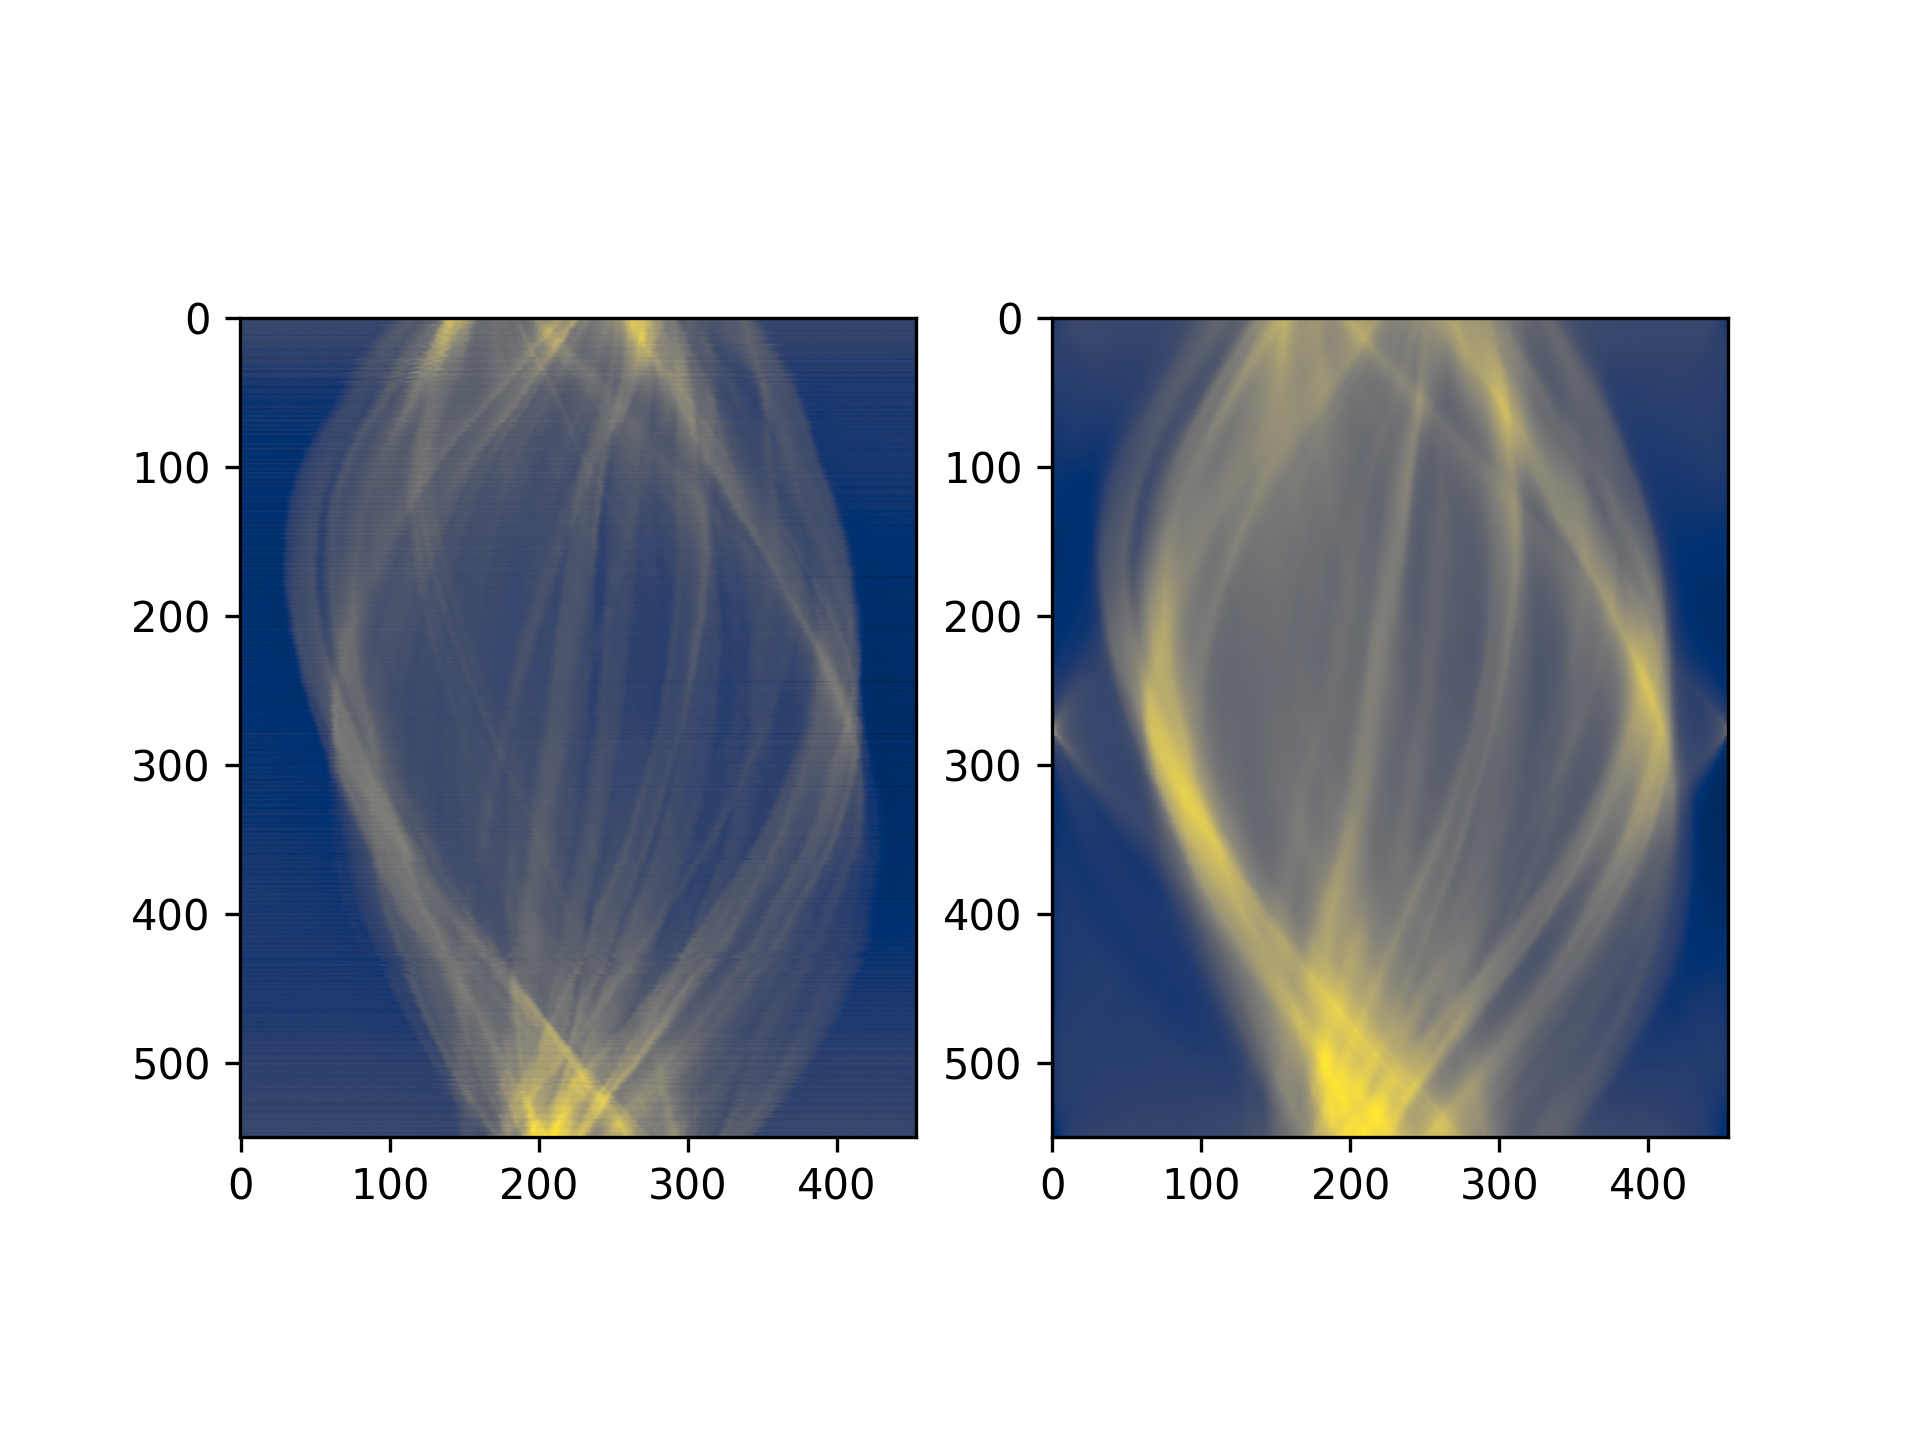

In [16]:
fig, ax = plt.subplots(1,2,dpi=300)
ax[0].imshow(-unwrapped3_coarse[:,unwrapped3_coarse.shape[1]//2,:])
# a = np.roll(reprojection[:,reprojection.shape[1]//2,:],reprojection.shape[1]//2,axis=0)
a = reprojection[:,reprojection.shape[1]//2,:]
# a = np.sum(reprojection,axis=1)
ax[1].imshow(a)

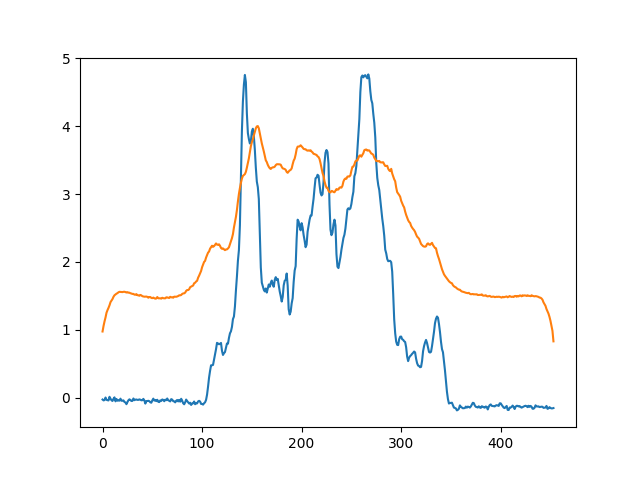

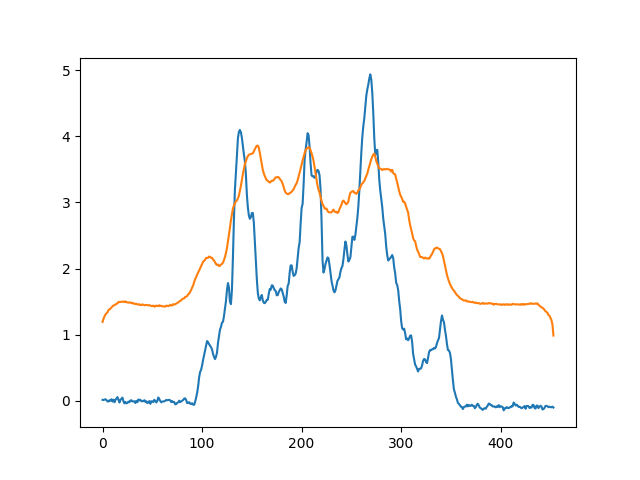

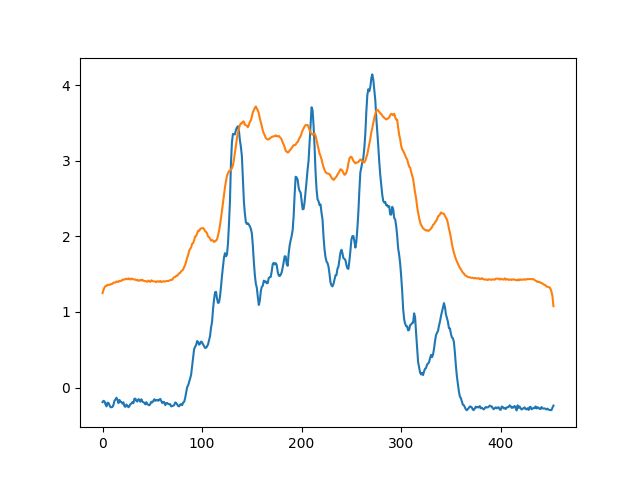

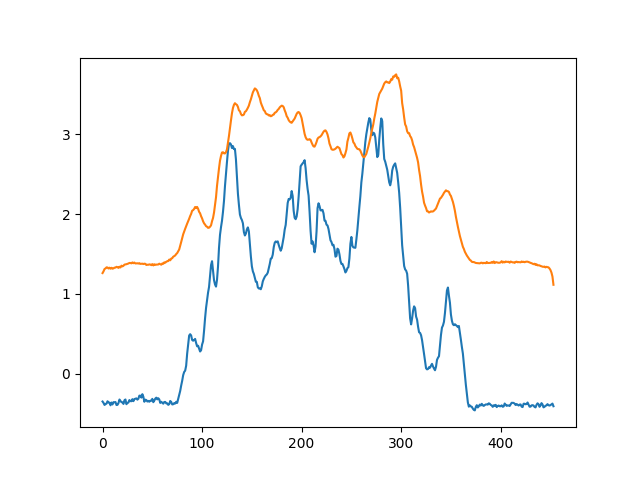

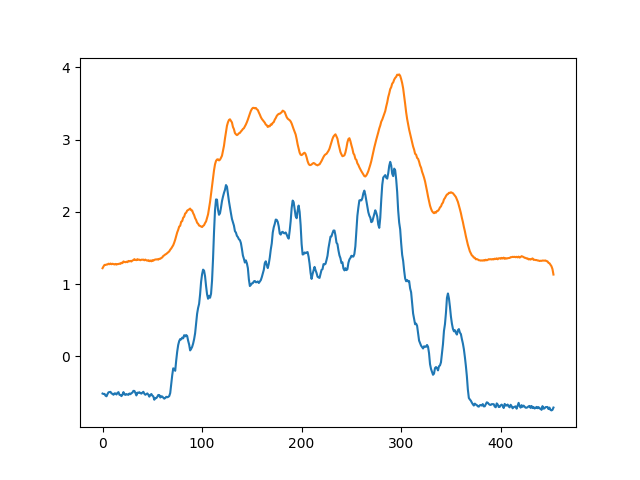

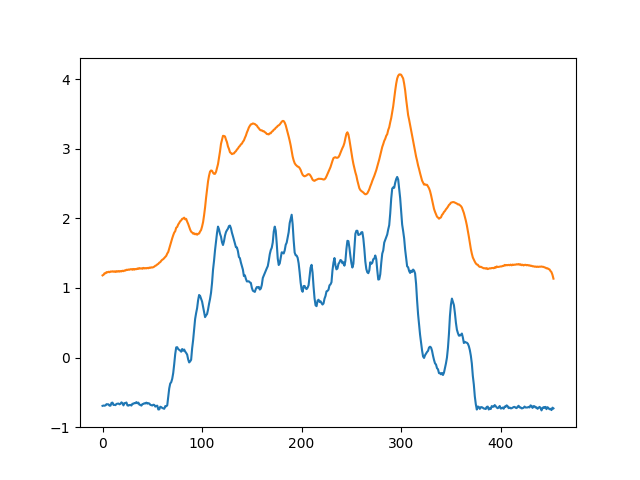

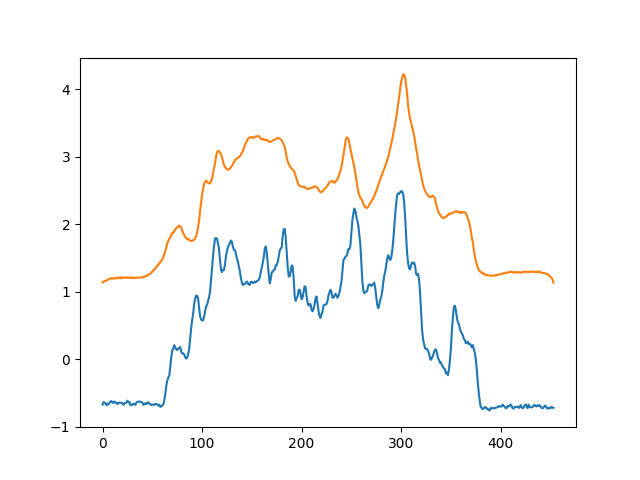

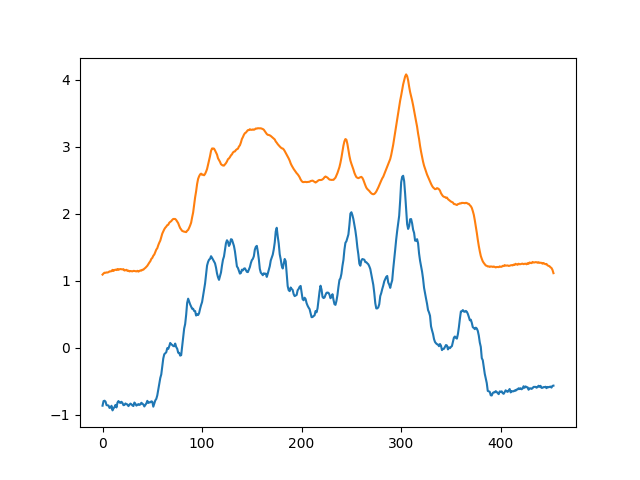

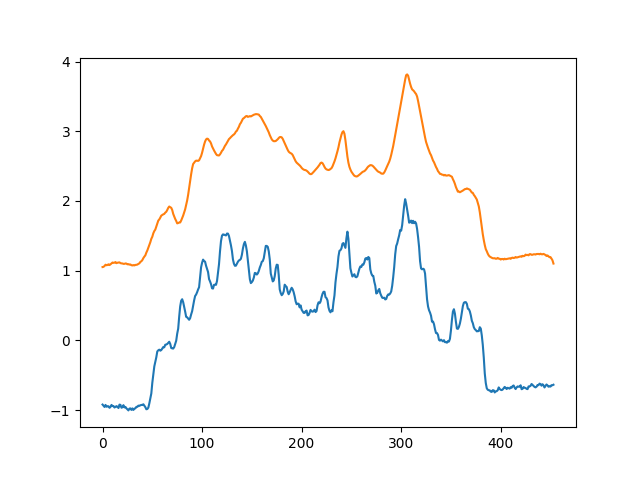

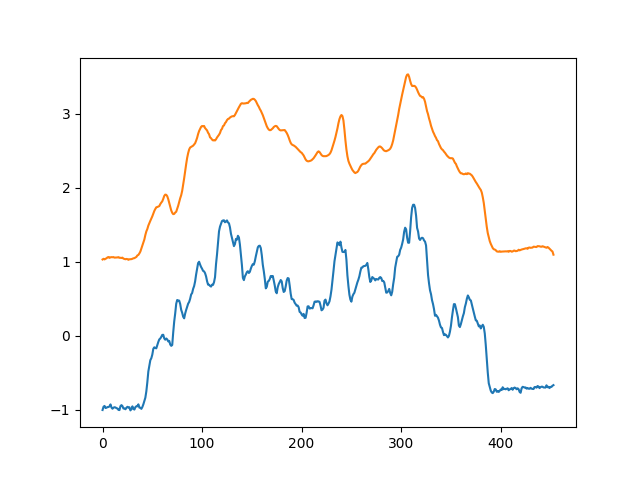

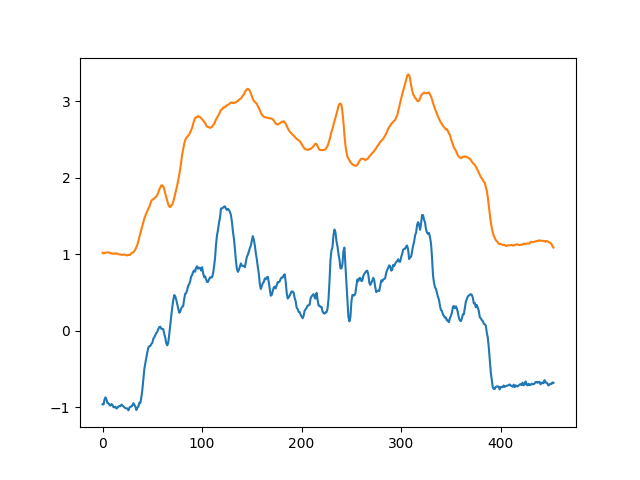

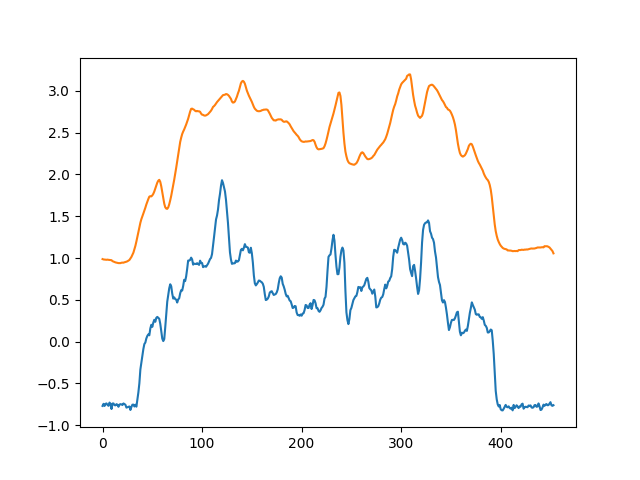

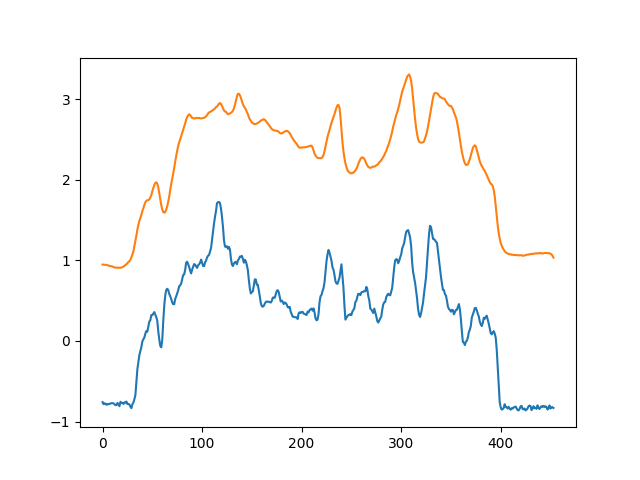

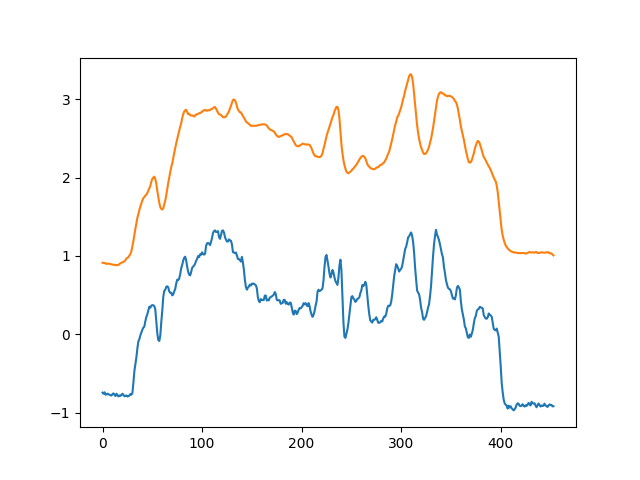

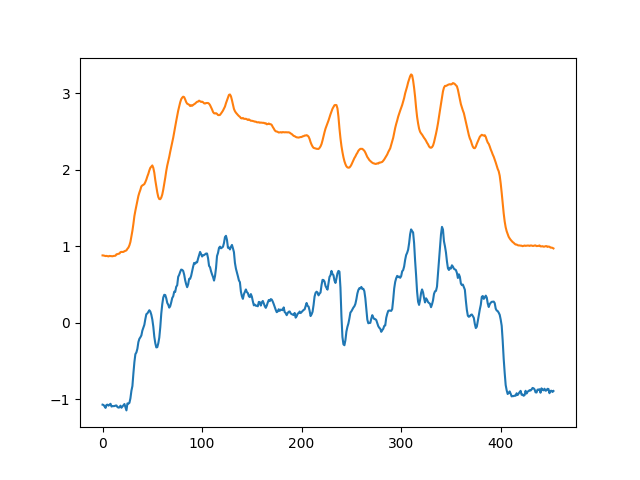

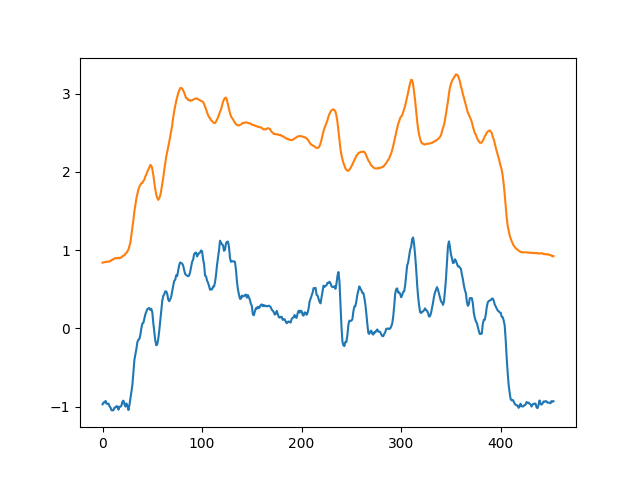

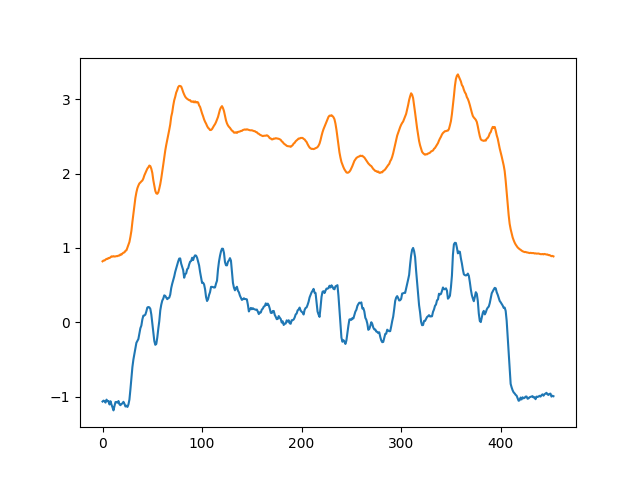

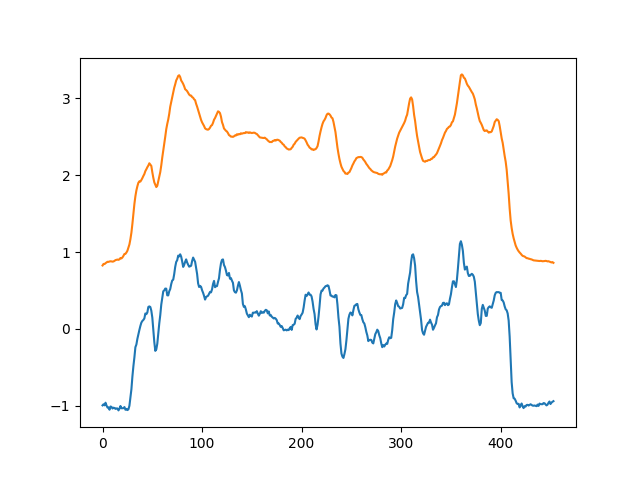

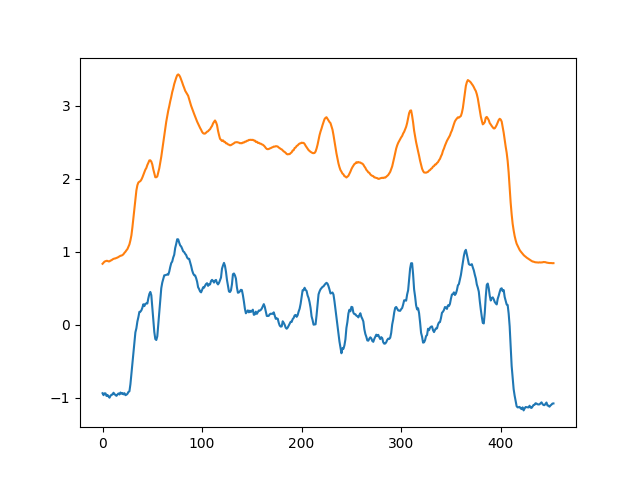

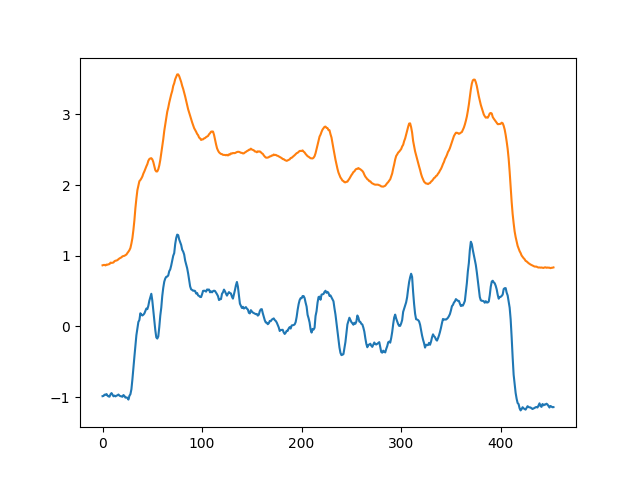

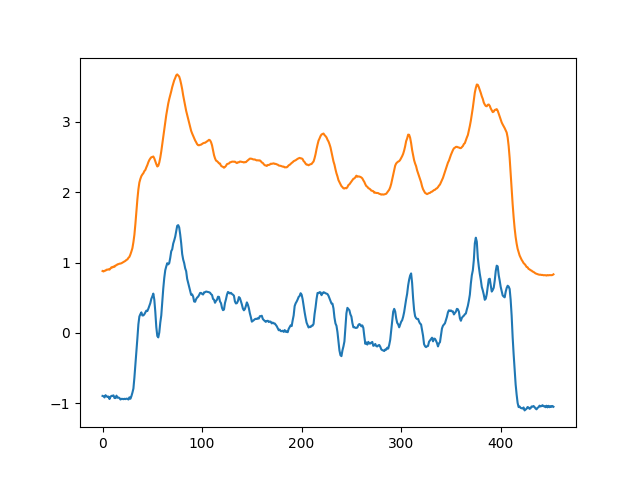

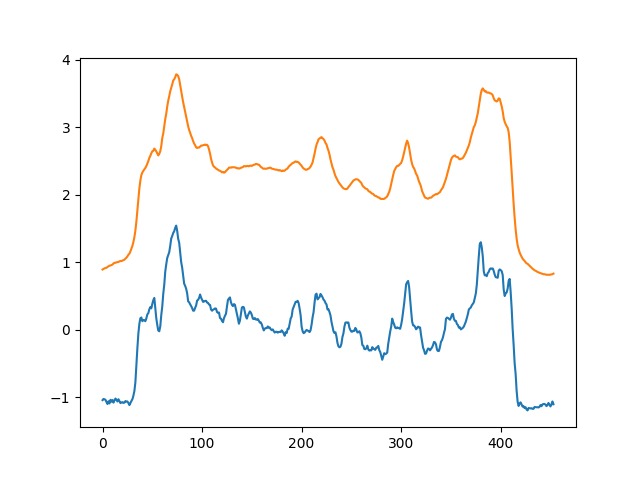

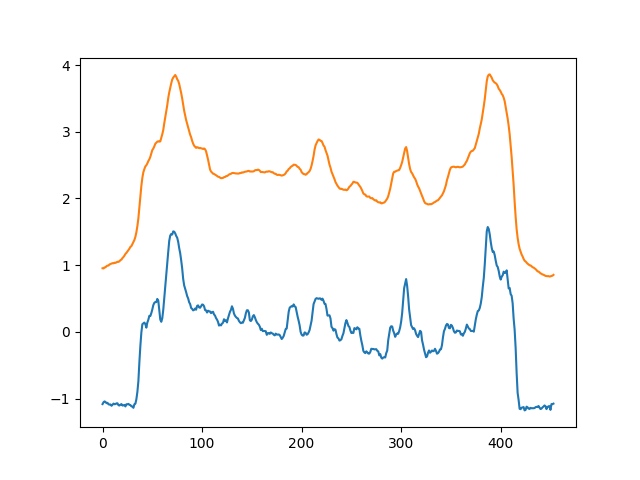

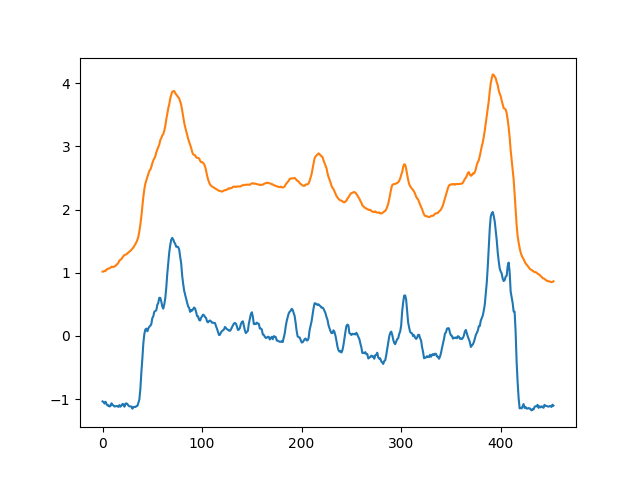

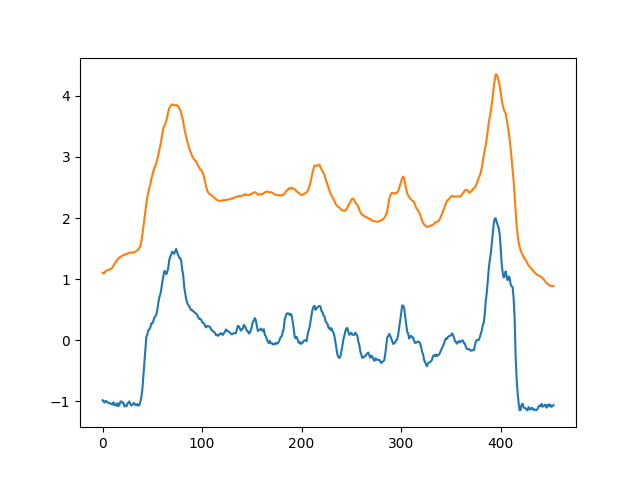

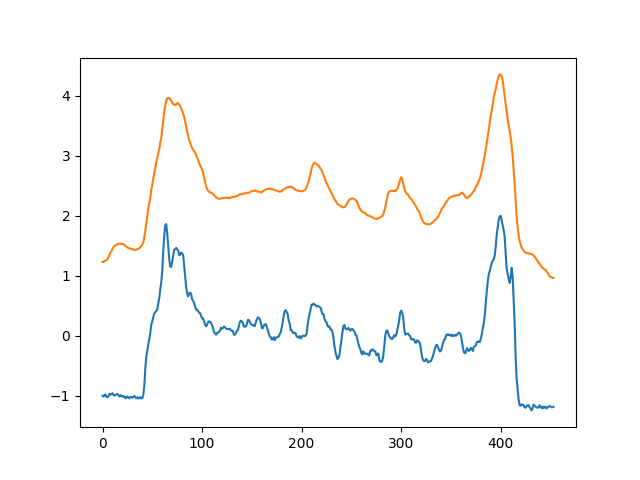

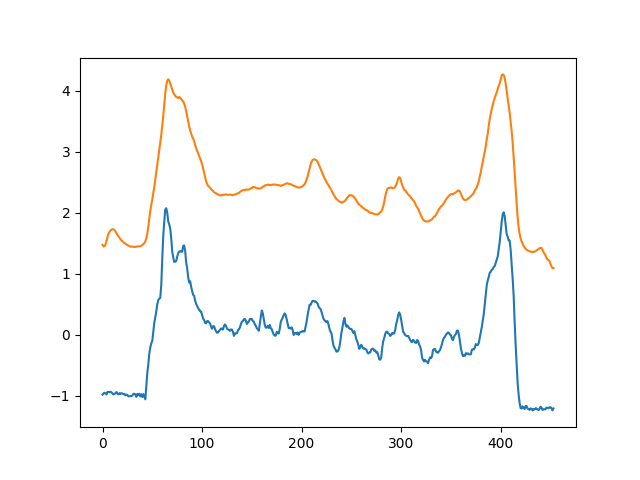

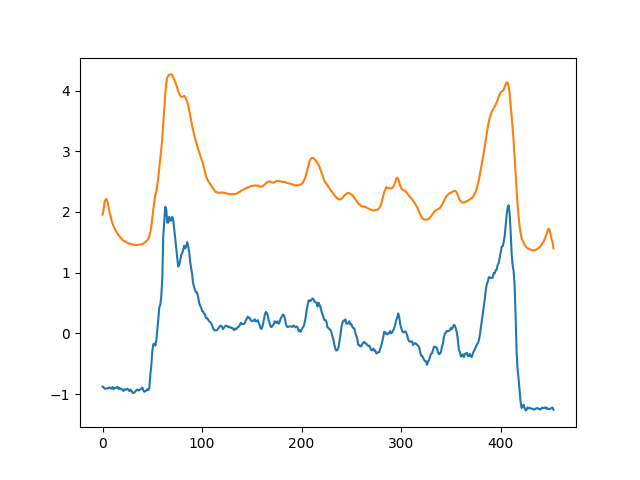

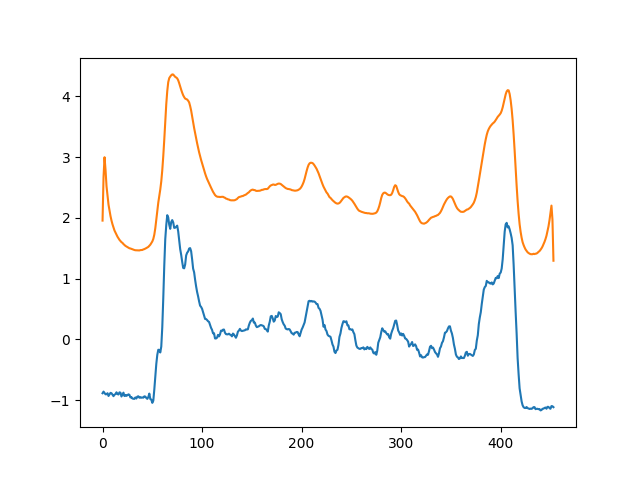

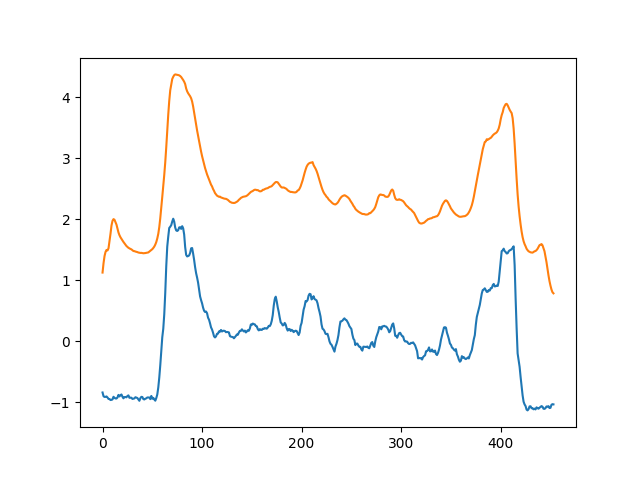

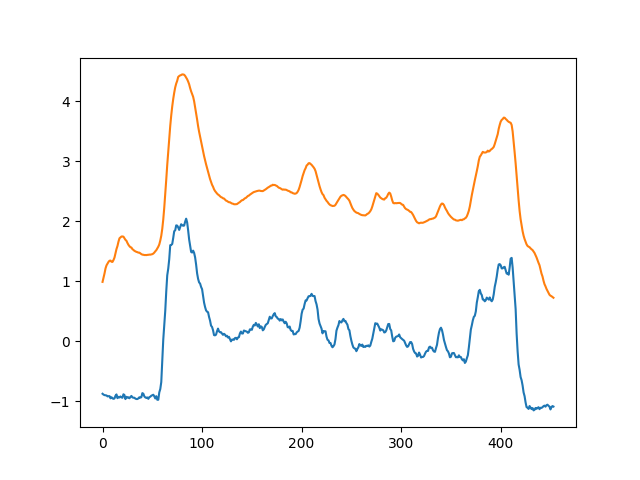

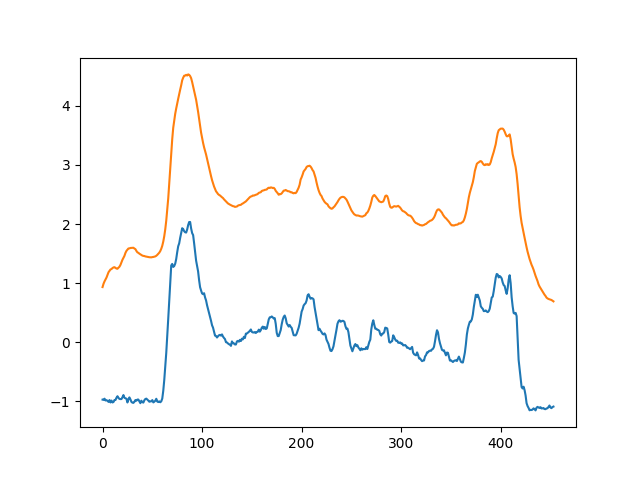

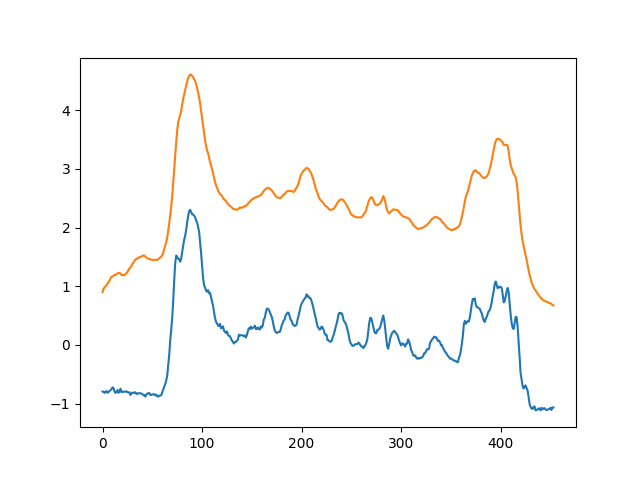

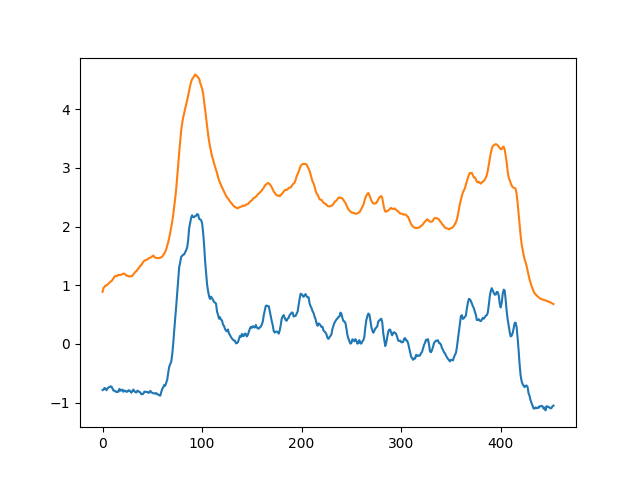

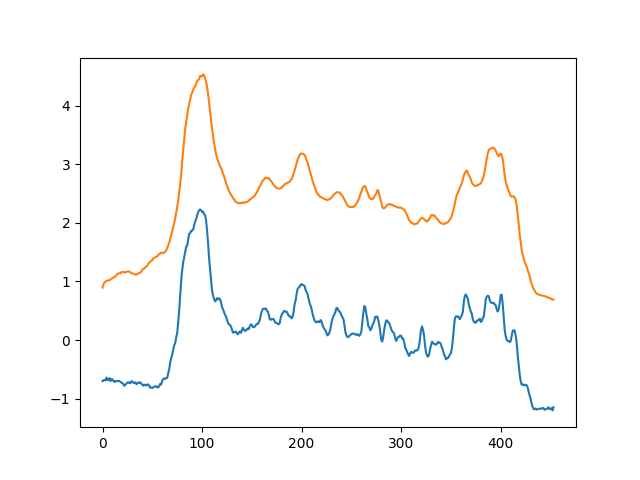

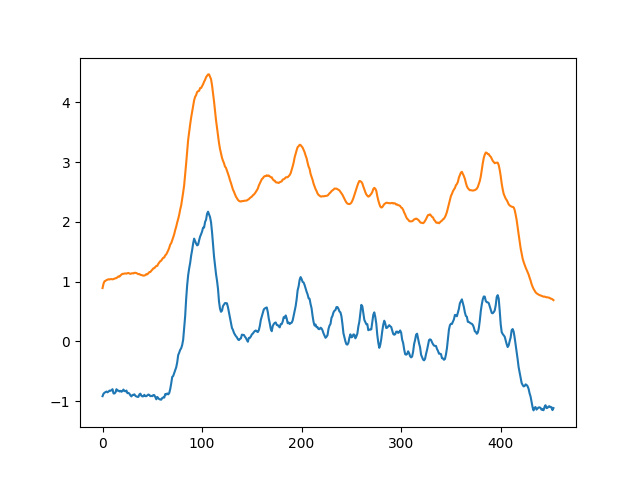

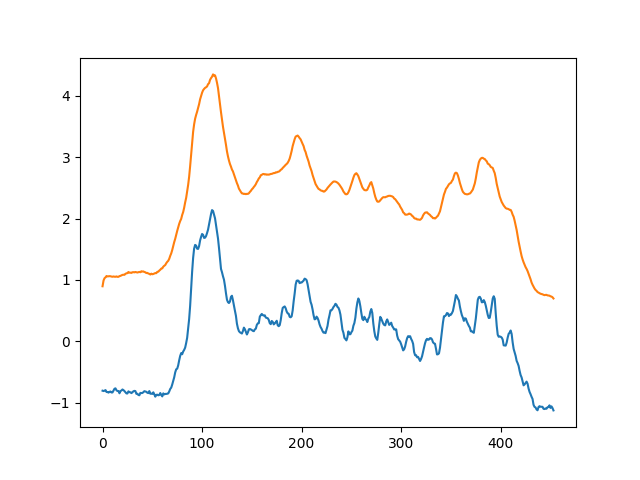

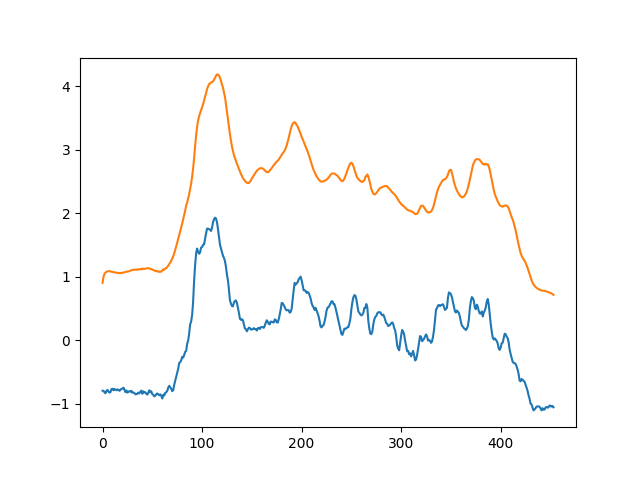

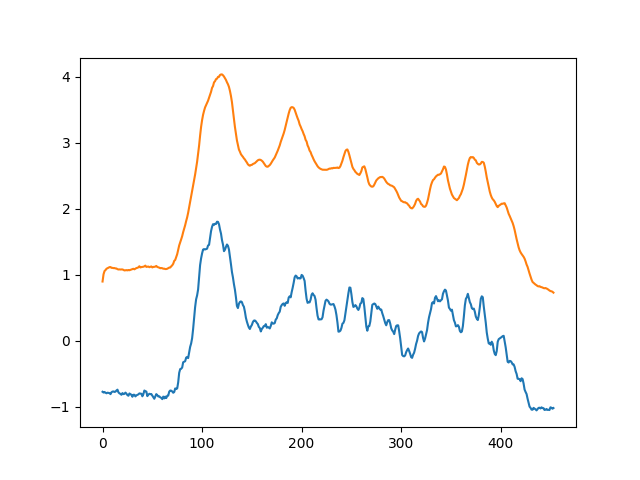

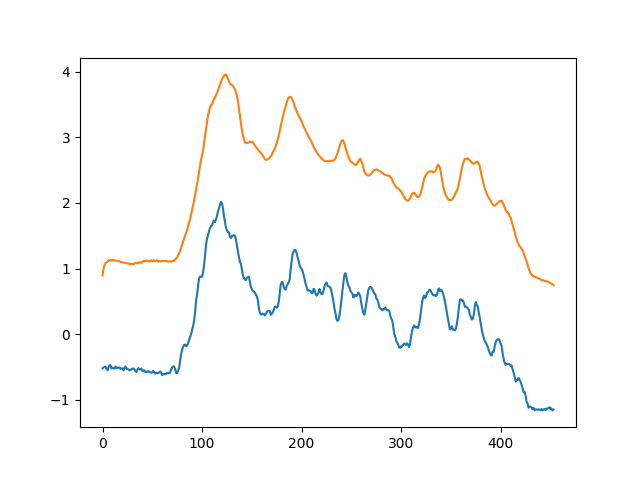

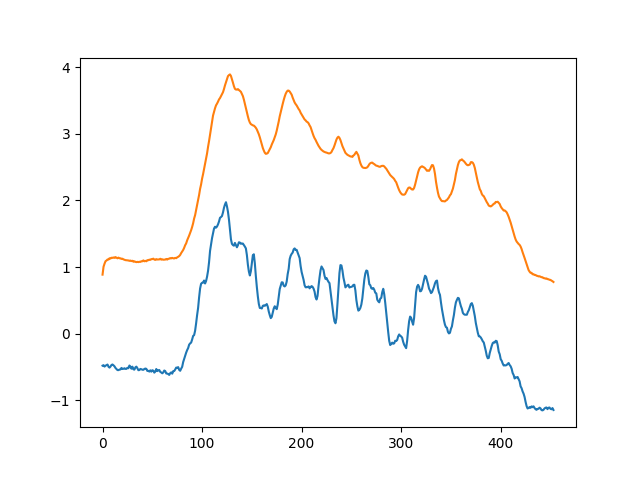

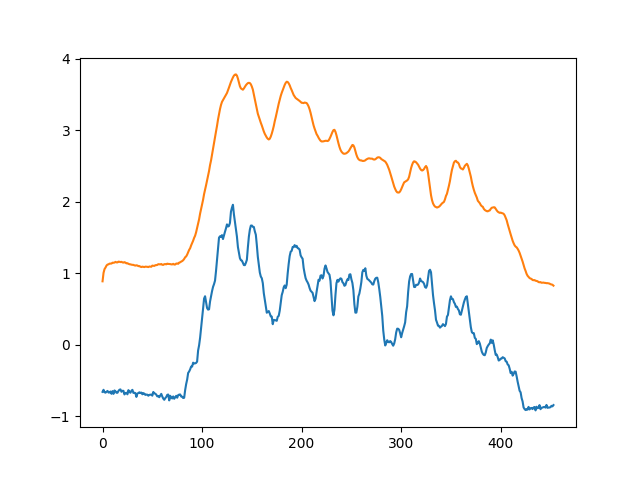

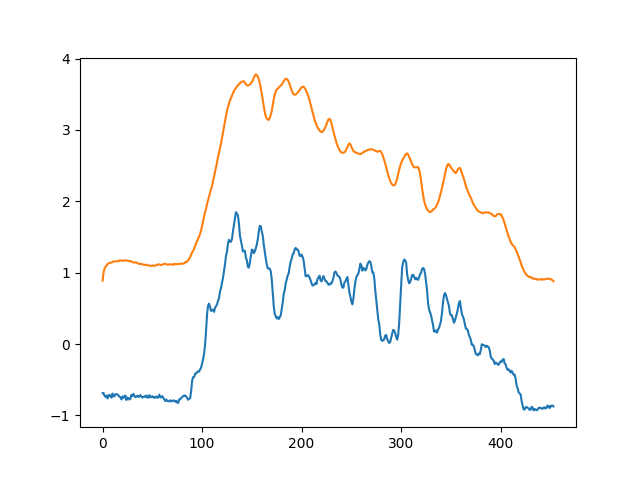

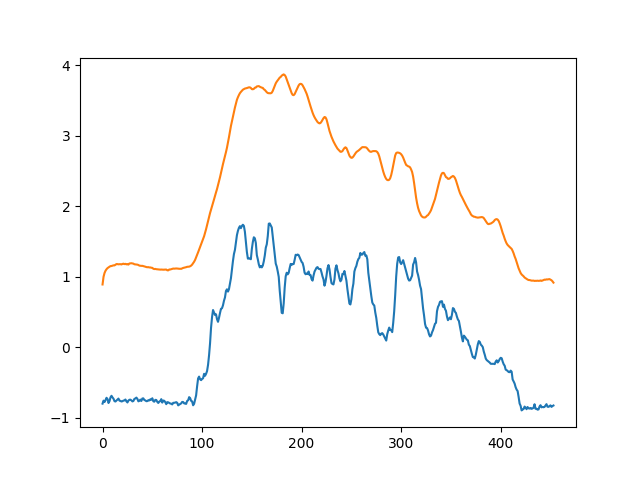

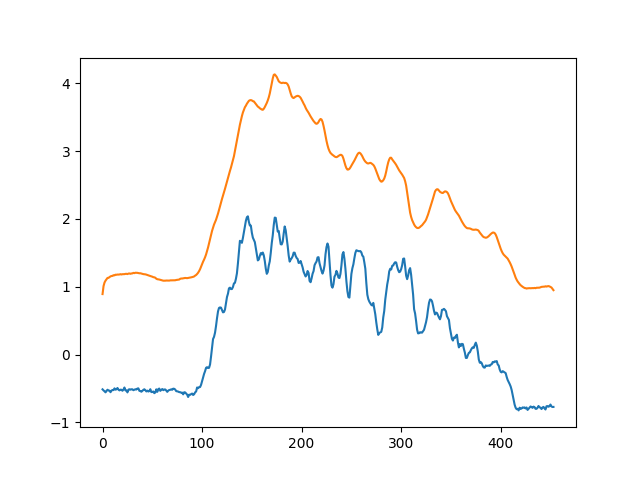

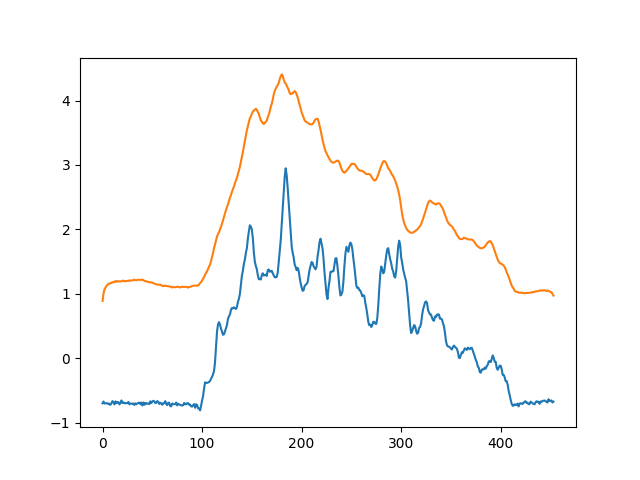

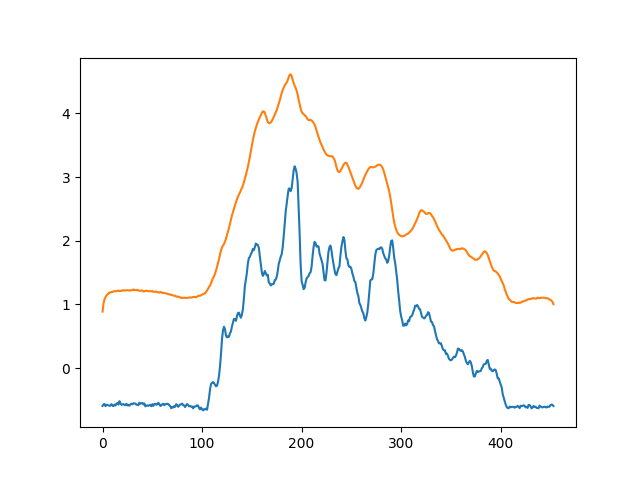

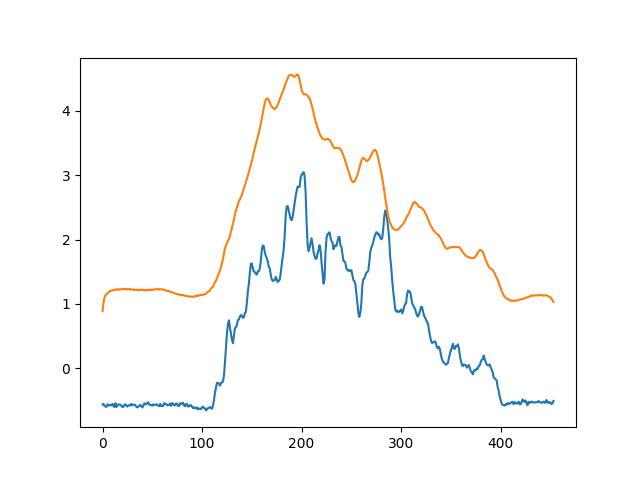

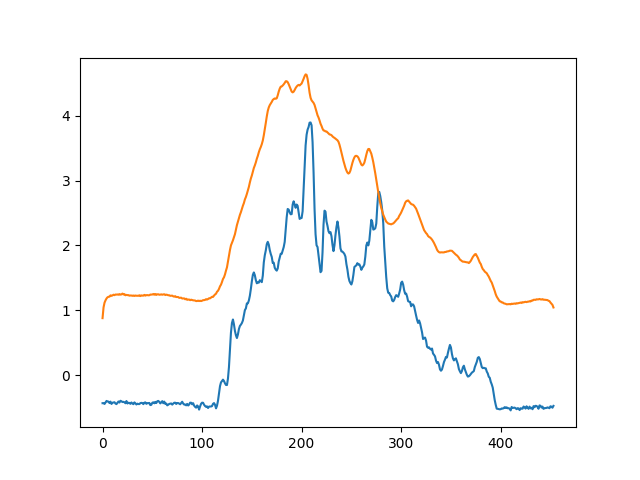

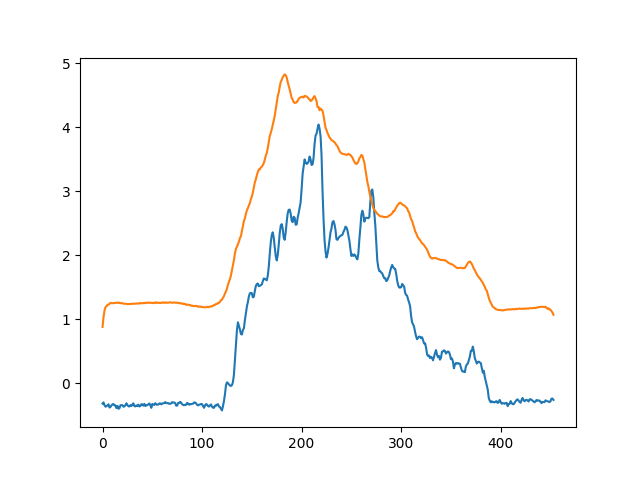

In [21]:
i = 0
for i in range(0,500,10):
    sliceA = -unwrapped3_coarse[i,unwrapped3_coarse.shape[1]//2,:]
    sliceB = reprojection[i,reprojection.shape[1]//2,:]

    fig, ax = plt.subplots()
    ax.plot(sliceA)
    ax.plot(sliceB)